# [GD-06] Bias in Word Embeddings
"Going Deeper Node 6. Checking Bias in Word Embeddings" / 2022. 04. 04 (MON) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Modeling**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

In [1]:
# Colab Pro GPU 정보
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  4 23:35:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Colab Pro Ram 정보
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
# STEP 2. 추출된 결과로 embedding model 만들기
# STEP 3. target, attribute 단어 셋 만들기
# STEP 4. WEAT score 계산과 시각화

## 1. Environment Setup

In [4]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 574 kB/s 
     |████████████████████████████████| 448 kB 29.5 MB/s 


In [7]:
import os
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf

import konlpy
from konlpy.tag import Okt

import gensim 
from gensim.models import Word2Vec

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn

import numpy as np
from numpy import dot
from numpy.linalg import norm

In [12]:
# path_to_zip 함수로 파일 압축을 풀고, 편리하게 불러올 수 있다.
path_to_zip = tf.keras.utils.get_file('synopsis.zip',
    origin='https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)
print(path_to_file)

/root/.keras/datasets


In [11]:
with open('/root/.keras/datasets/synopsis.txt','r') as file:
    for i in range(20):
      print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [13]:
# 토큰화

okt = Okt()
tokenized = []
with open('/root/.keras/datasets/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]: 
                res.append(w[0])
        tokenized.append(res)

In [14]:
print(len(tokenized))

71156


## 2. Modeling (Embedding Model)

In [15]:
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
model.most_similar(positive=['가족'])

[('부모', 0.7126961946487427),
 ('어머니', 0.7070084810256958),
 ('자식', 0.6927177906036377),
 ('규호', 0.6924899816513062),
 ('하인리히', 0.6624774932861328),
 ('증조', 0.6599054336547852),
 ('자녀', 0.6556708812713623),
 ('형제', 0.655502200126648),
 ('무릅', 0.6421080827713013),
 ('화해', 0.6414533257484436)]

In [16]:
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
model.most_similar(positive=['사극'])

[('디테일', 0.9802770614624023),
 ('만하', 0.9767768383026123),
 ('물씬', 0.9763075113296509),
 ('영화인', 0.9742345809936523),
 ('전반', 0.9727168679237366),
 ('그래픽', 0.9718895554542542),
 ('삽화', 0.9716793298721313),
 ('주제가', 0.9704302549362183),
 ('리얼리즘', 0.969849169254303),
 ('휴머니즘', 0.9698436260223389)]

In [17]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('/root/.keras/datasets/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽는 중입니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [18]:
art = read_token(art_txt)  # 예술 영화
gen = read_token(gen_txt)  # 일반 영화

print(type(art), type(gen))
print(len(art), len(gen))

synopsis_art.txt 파일을 읽는 중입니다.
synopsis_gen.txt 파일을 읽는 중입니다.
<class 'str'> <class 'str'>
620208 3014815


In [20]:
# art_txt, gen_txt에서 각각 50번째까지 글자 데이터

print(art[:50])
print(gen[:50])

사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 
유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작


In [21]:
# TF-IDF Vocab Set

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [22]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬

print('예술영화를 대표하는 단어 목록:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어 목록:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어 목록:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어 목록:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [23]:
# 중복단어 제거
n = 30
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 30개 추출
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
        
    if len(target_art) == n: 
        break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 30개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
    if len(target_gen) == n: 
        break

In [24]:
len(w1_), len(w2_)

print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체', '한국']


In [25]:
# 장르별 파일들 로드
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

print(len(genre))

# TF-IDF Vocab Set
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

# 각 장르별 대표단어 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

synopsis_SF.txt 파일을 읽는 중입니다.
synopsis_family.txt 파일을 읽는 중입니다.
synopsis_show.txt 파일을 읽는 중입니다.
synopsis_horror.txt 파일을 읽는 중입니다.
synopsis_etc.txt 파일을 읽는 중입니다.
synopsis_documentary.txt 파일을 읽는 중입니다.
synopsis_drama.txt 파일을 읽는 중입니다.
synopsis_romance.txt 파일을 읽는 중입니다.
synopsis_musical.txt 파일을 읽는 중입니다.
synopsis_mystery.txt 파일을 읽는 중입니다.
synopsis_crime.txt 파일을 읽는 중입니다.
synopsis_historical.txt 파일을 읽는 중입니다.
synopsis_western.txt 파일을 읽는 중입니다.
synopsis_adult.txt 파일을 읽는 중입니다.
synopsis_thriller.txt 파일을 읽는 중입니다.
synopsis_animation.txt 파일을 읽는 중입니다.
synopsis_action.txt 파일을 읽는 중입니다.
synopsis_adventure.txt 파일을 읽는 중입니다.
synopsis_war.txt 파일을 읽는 중입니다.
synopsis_comedy.txt 파일을 읽는 중입니다.
synopsis_fantasy.txt 파일을 읽는 중입니다.
21
(21, 42191)
SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령,

In [33]:
# WEAT SCORE

# 1. Word Embedding의 유사도를 측정하여 단어를 분류하거나 편향성을 측정한다.
# 2. 유사도 측정은 코싸인 유사도를 사용한다.
# 3. 편향값은 -2에서 2 사이의 값을 가진다. 이를 정규화하면 최종 WEAT SCORE가 나온다.

target_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
target_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

attribute_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
attribute_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}

## target_x, y
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

# attribute a, b
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]
[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [35]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b

print(s(target_X['웃음'], A, B))
print(s(target_Y['증오'], A, B))

0.45992664921259363
-0.7037872506314451


In [36]:
# 평균값 계산 (target x-y, attribute a-b)
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B) # x의 편향
    s_Y = s(Y, A, B) # y의 편향 

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# WEAT score
print(round(weat_score(X, Y, A, B), 3))

[0.37181942 0.41632807 0.21117431]
0.333
[-0.39609272 -0.37389852 -0.41242037]
-0.394
1.97


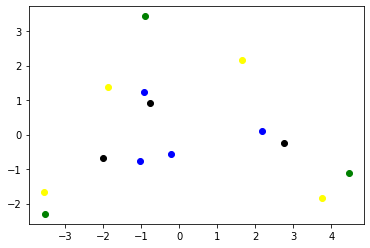

In [38]:
# Visualization

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
## attribute a-b
ax.scatter(pc_A[:,0],pc_A[:,1], c='yellow', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='blue', label='B')
## target x-y
ax.scatter(pc_X[:,0],pc_X[:,1], c='green', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='black', label='Y')

## x-a(green-yellow) / y-b(black-blue)가 서로 가깝게 위치해 있다.

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


SF 멜로로맨스 -1.37173
공포(호러) 다큐멘터리 1.1574864
기타 멜로로맨스 -1.2170857
다큐멘터리 멜로로맨스 -1.5356116
다큐멘터리 미스터리 -1.3113083
다큐멘터리 성인물(에로) -1.3223479
다큐멘터리 스릴러 -1.2176847
멜로로맨스 뮤지컬 1.1301728
멜로로맨스 범죄 1.239678
멜로로맨스 서부극(웨스턴) 1.1959556
멜로로맨스 애니메이션 1.2504267
멜로로맨스 액션 1.161332
멜로로맨스 전쟁 1.4724622
미스터리 전쟁 1.1169102
성인물(에로) 전쟁 1.1411737


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


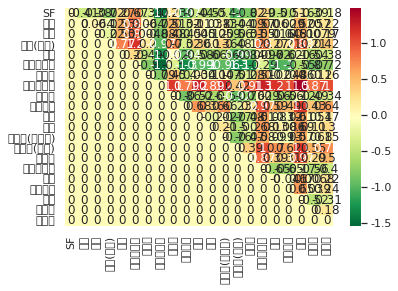

In [52]:
# attribute A : '드라마'
# attribute B : '액션'
# target X : art, 예술영화
# target Y : gen, 일반영화

## 구현결과를 담을 matrix (21x21)
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])

np.random.seed(0)

# Visualization
## Source: https://rfriend.tistory.com/419, https://mingchin.tistory.com/80?category=971417

import seaborn as sns; 

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic",
rc={"axes.unicode_minus":False}, style='darkgrid')
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# 색깔 분포와 아래 수치를 보면 멜로로맨스류가 가장 편향값이 높다.

## 3. Project Retrospective

+ 바로 위에 있는 한글 깨짐을 해결하려고 다양한 코드를 시도했는데 해결하지 못했다. Colab 자체의 문제인가 싶다. 그래도 데이터셋을 다운로드나 저장 없이 바로 압축을 풀어서 진행한 것은 꽤 쾌적한 느낌을 받았다.
+ 데이터 편향을 평가하고, 이해할 수 있는 지표가 있다는 건 신기하다.
+ 예시 데이터(곤충, 꽃)를 생성하는 방법에 대해 조금 더 공부하고 싶다. 조금 더 내가 좋아하는 단어들로 다르게 표현하고 싶었는데 그 부분을 구현하지 못한 것은 아쉽다.
+ 이렇게 중복 데이터가 많은 데이터셋에서, 중복을 얼마나 덜어낼 것이냐는 오롯이 데이터 엔지니어의 몫일텐데 그 '정도'를 측정하려면 꽤나 머리가 아플듯 하다.